In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# read a file
gdrive_path = '/content/drive/MyDrive/mydata/'

**Import Data and Data Visualization**

In [3]:
#read the reviews
import pandas as pd

data = pd.read_csv("IMDB_Dataset.csv", error_bad_lines=False)
data.sample(n=10)

<ipython-input-3-297507c9285a>:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv("IMDB_Dataset.csv", error_bad_lines=False)


,review,sentiment
41214,"The thing about calling ""House of the Dead"" th...",negative
10093,"Every great once in a while, you stumble upon ...",positive
31132,"I must admit, there are few books with corresp...",negative
15407,"Rendered in beautiful water colors, Ponyo At T...",positive
14353,* Some spoilers *<br /><br />This movie is som...,negative
44913,Describing this film is a difficult task. On t...,negative
21275,This movie was a sicky sweet cutesy romantic c...,positive
32821,I saw this movie and thought it was a sleeper....,negative
15432,Heard about this film a long while ago and fin...,positive
4185,It would appear that some previous reviewers m...,positive


In [4]:
data.groupby('sentiment').describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   25000  24698  This show comes up with interesting locations ...   
positive   25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
sentiment       
negative     3  
positive     5

In [5]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

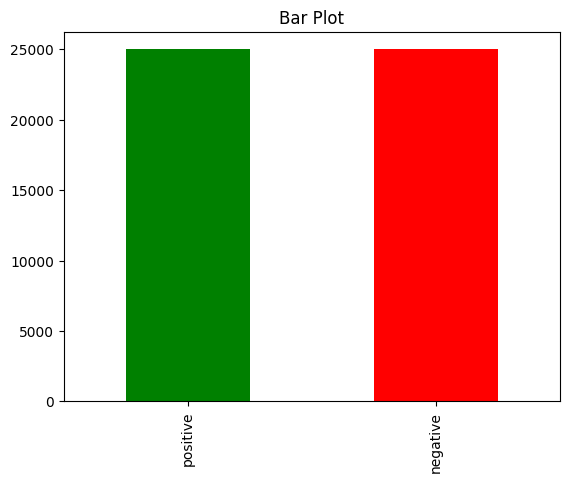

In [6]:
import matplotlib.pyplot as plt

count_Class=pd.value_counts(data["sentiment"], sort= True)
count_Class.plot(kind = 'bar',color = ["green","red"])
plt.title('Bar Plot')
plt.show()

In [7]:
data['label'] = data['sentiment'].replace(['positive', 'negative'],['1', '0'])

In [8]:
neg_data  = data[data['label'] == 0].copy()
pos_data = data[data['label'] == 1].copy()

**Import Modules**

In [9]:
# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
from collections import Counter
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

In [10]:
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "positive"
NEGATIVE = "negative"
NEUTRAL = "neutral"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "Sentiment_sg_bilstm_w2v.sav"
WORD2VEC_MODEL = "sg_model.w2v"
TOKENIZER_MODEL = "sg_bilstm_w2v_tokenizer.pkl"
ENCODER_MODEL = "sg_encoder.pkl"


Text(0.5, 1.0, 'Dataset labels distribuition')

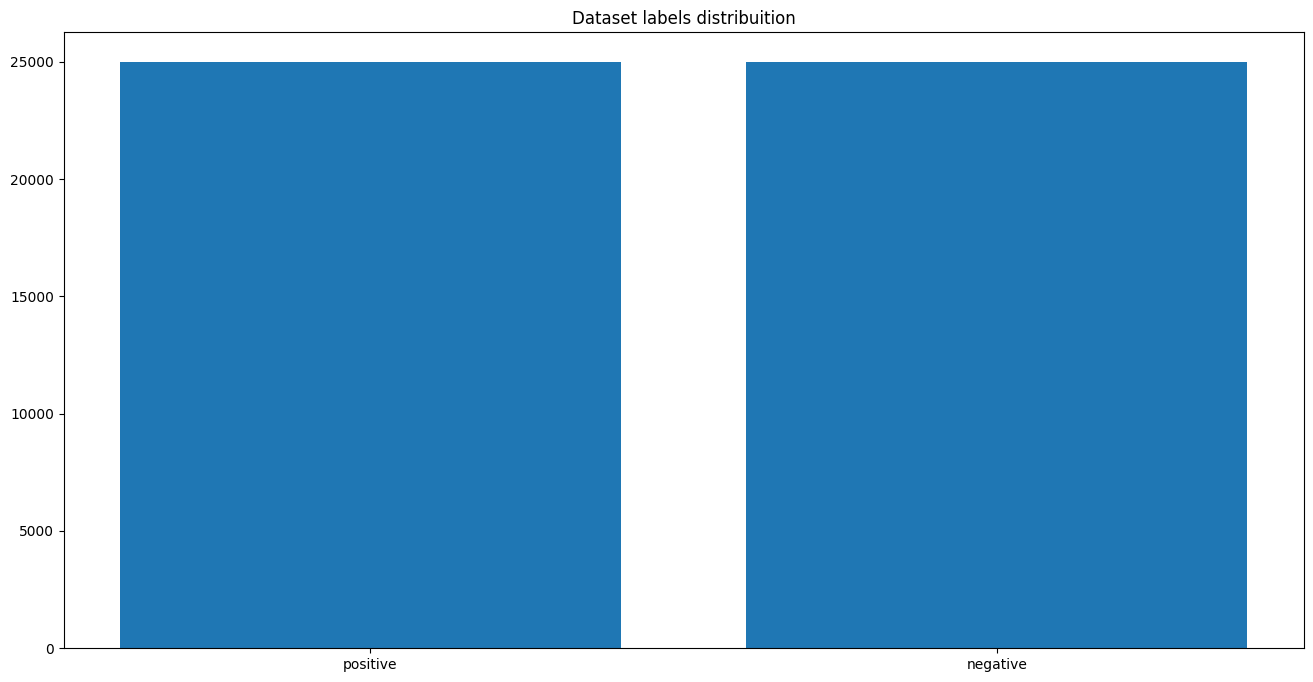

In [11]:
target_cnt = Counter(data.sentiment)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

**Data Preprocessing**

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [14]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [15]:
%%time
data.review = data.review.apply(lambda x: preprocess(x))

CPU times: user 28.4 s, sys: 55.2 ms, total: 28.5 s
Wall time: 28.7 s


In [16]:
data.sample(n=10)

,review,sentiment,label
2227,well suppose know dumb ass promotional lordi m...,negative,0
45085,surely one best british films ever made one be...,positive,1
38020,sudden impact overall better enforcer opinion ...,positive,1
7542,saw movie child longing see survived discount ...,positive,1
3016,michael king film contains best stuff mike eve...,positive,1
20804,right movie better book get wrong love book mo...,positive,1
1308,granted seems like good idea steve martin gold...,negative,0
20777,intriguingly bold film weaves seemingly effort...,positive,1
26423,funny intelligent sense realistic comedy 14 ye...,positive,1
37600,antonioni wim wenders best best story characte...,positive,1


In [17]:
# split data into train and test set
X = data['review'].values
y = data['sentiment'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [18]:
%%time
documents = [_text.split() for _text in data.review]

CPU times: user 444 ms, sys: 158 ms, total: 602 ms
Wall time: 604 ms


In [19]:
print(len(documents))

50000


**Skip Gram Word2Vec Model Training**

In [20]:
# Train Skip Gram Word2Vec model
w2vmodel = gensim.models.Word2Vec(documents, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8, sg=1)


In [21]:
words = w2vmodel.wv.index_to_key
vocab_size_wv = len(words)
print("Vocab size:", vocab_size_wv)

Vocab size: 28058


In [22]:
w2vmodel.wv.most_similar("movie")

[('film', 0.7929317951202393),
 ('sequal', 0.7252863645553589),
 ('havent', 0.7165814638137817),
 ('atleast', 0.7165090441703796),
 ('strangeland', 0.7090111970901489),
 ('couldnt', 0.701482355594635),
 ('wouldnt', 0.6896225810050964),
 ('summery', 0.6820045709609985),
 ('hesitated', 0.6737769842147827),
 ('meh', 0.6689944267272949)]

**Tokenization**

In [23]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.review)



CPU times: user 4.69 s, sys: 121 ms, total: 4.81 s
Wall time: 4.72 s


In [24]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 100947


**Data Preparation for Model Training**

In [25]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

CPU times: user 3.33 s, sys: 111 ms, total: 3.44 s
Wall time: 3.42 s


In [26]:
labels = data.sentiment.unique().tolist()
labels.append("neutral")
labels

['positive', 'negative', 'neutral']

In [27]:
encoder = LabelEncoder()
encoder.fit(data.sentiment.tolist())

y_train = encoder.transform(Y_train.tolist())
y_test = encoder.transform(Y_test.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (40000, 1)
y_test (10000, 1)


In [28]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (40000, 300)
y_train (40000, 1)

x_test (10000, 300)
y_test (10000, 1)


In [29]:
y_train[:10]

array([[0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]])

**Embedding layer**

In [30]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2vmodel.wv:
        embedding_matrix[i] = w2vmodel.wv[word]
print(embedding_matrix.shape)

(100947, 300)


In [31]:
# create embedding layer
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

**Build Model**

In [32]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          30284100  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 bidirectional (Bidirection  (None, 200)               320800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 30605101 (116.75 MB)
Trainable params: 321001 (1.22 MB)
Non-trainable params: 30284100 (115.52 MB)
_________________________________________________________________


**Compile model**

In [33]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

**Callbacks**

In [34]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)] #change 'val_acc' to 'val_accuracy'

**Train**

In [35]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

model.save(KERAS_MODEL)
w2vmodel.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)



Epoch 1/32
36/36 [==============================] - 103s 3s/step - loss: 0.5058 - accuracy: 0.7565 - val_loss: 0.3304 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 2/32
36/36 [==============================] - 91s 3s/step - loss: 0.3509 - accuracy: 0.8525 - val_loss: 0.3543 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 3/32
36/36 [==============================] - 93s 3s/step - loss: 0.3226 - accuracy: 0.8633 - val_loss: 0.3675 - val_accuracy: 0.8727 - lr: 0.0010
Epoch 4/32
36/36 [==============================] - 91s 3s/step - loss: 0.3262 - accuracy: 0.8645 - val_loss: 0.3042 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 5/32
36/36 [==============================] - 91s 3s/step - loss: 0.3118 - accuracy: 0.8689 - val_loss: 0.4111 - val_accuracy: 0.8390 - lr: 0.0010
Epoch 6/32
36/36 [==============================] - 90s 3s/step - loss: 0.3172 - accuracy: 0.8677 - val_loss: 0.3284 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 7/32
36/36 [==============================] - 89s 2s/step - loss: 0.2986 - 

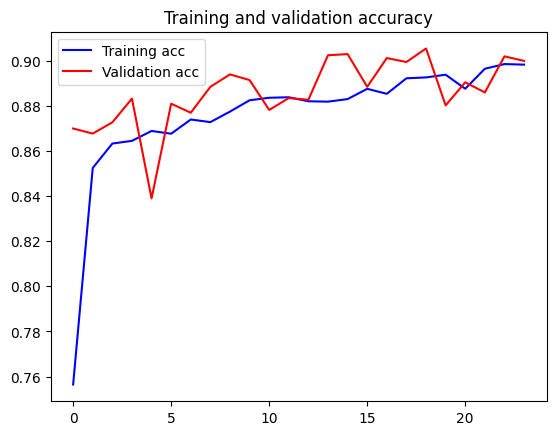

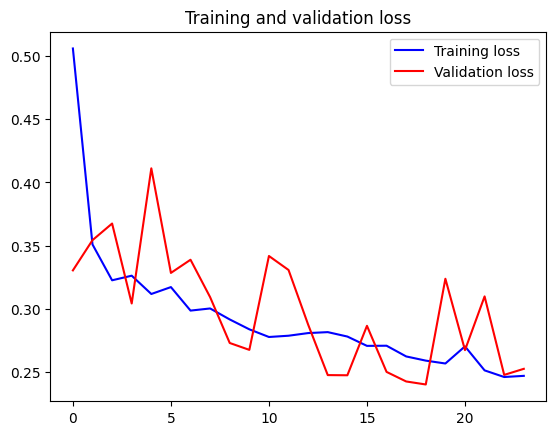

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Evaluate Model using Test Data**

In [37]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 2s 217ms/step - loss: 0.2473 - accuracy: 0.9018

ACCURACY: 0.9017999768257141
LOSS: 0.24730978906154633
CPU times: user 1.91 s, sys: 393 ms, total: 2.3 s
Wall time: 2.62 s


**Predict**

In [39]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [40]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [41]:
predict("I think this is a very great movie.")

1/1 [==============================] - 1s 560ms/step


{'label': 'positive',
 'score': 0.7522115707397461,
 'elapsed_time': 0.6069424152374268}

**Confusion Matrix**

In [42]:
%%time
y_pred_1d = []
y_test_1d = list(Y_test)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 2s 356ms/step
CPU times: user 1.39 s, sys: 554 ms, total: 1.95 s
Wall time: 1.94 s


In [43]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

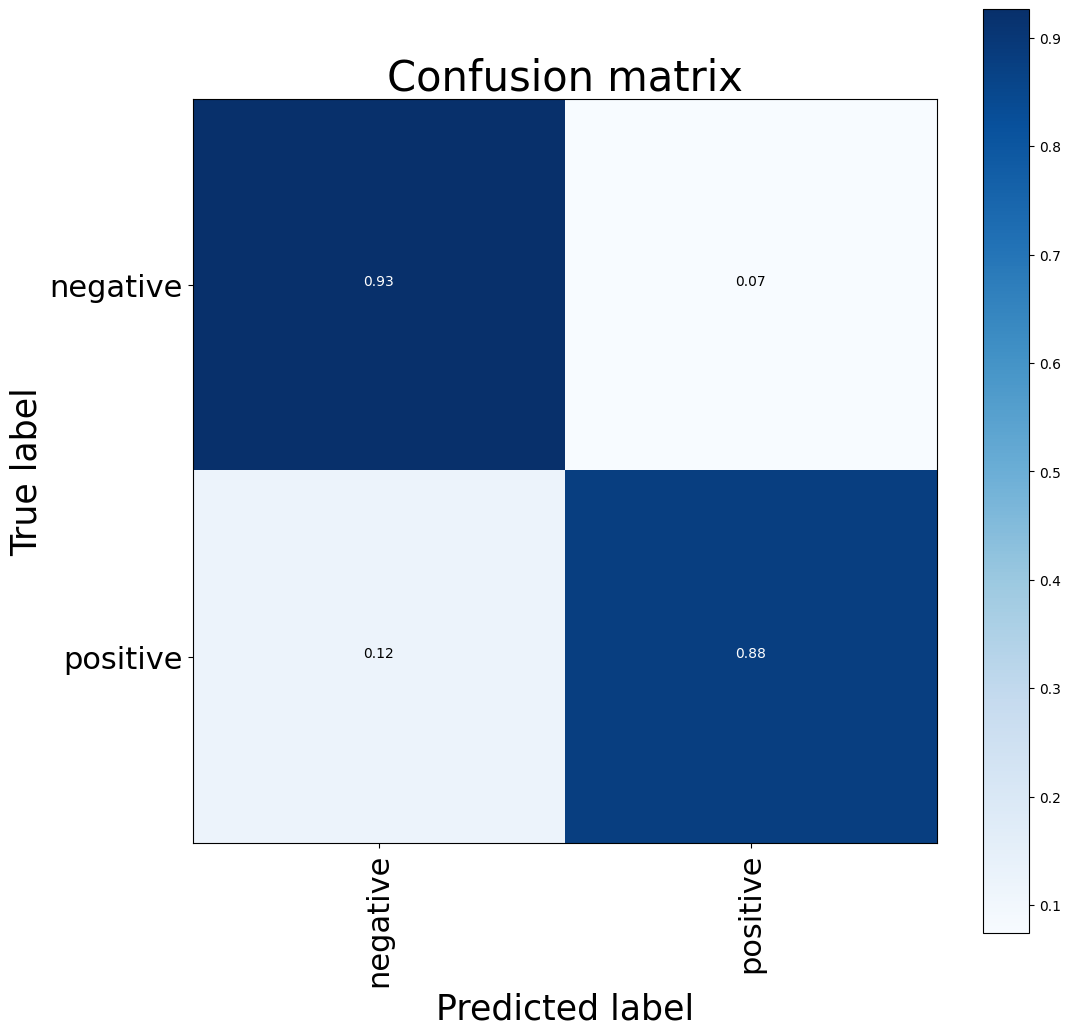

CPU times: user 411 ms, sys: 249 ms, total: 660 ms
Wall time: 401 ms


In [44]:
%%time
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(Y_train), title="Confusion matrix")
plt.show()

**Classification Report**

In [45]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    negative       0.88      0.93      0.90      4961
    positive       0.92      0.88      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



**Accuracy Score**

In [46]:
accuracy_score(y_test_1d, y_pred_1d)

0.9018

**Save model**

In [47]:
model.save(f"{gdrive_path}{KERAS_MODEL}")
w2vmodel.save(f"{gdrive_path}{WORD2VEC_MODEL}")
pickle.dump(tokenizer, open(f"{gdrive_path}{TOKENIZER_MODEL}", "wb"), protocol=0)
pickle.dump(encoder, open(f"{gdrive_path}{ENCODER_MODEL}", "wb"), protocol=0)

In [48]:
# download the trained model
import shutil
shutil.make_archive("/content/drive/MyDrive/mydata", 'zip', "/content/drive/MyDrive/mydata")

from google.colab import files
files.download("/content/drive/MyDrive/mydata.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>